## Proposition de GPT sur la régression pénalisante

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

class RollingOkunRegression:
    def __init__(self, window_size=14):  # Window size from paper @16
        self.window_size = window_size
        
    def fit(self, gdp_growth, unemployment_change):
        n = len(gdp_growth)
        okun_coefficients = []
        
        for i in range(n - self.window_size + 1):
            # Extract window data
            X = gdp_growth[i:i+self.window_size]
            y = unemployment_change[i:i+self.window_size]
            
            # Calculate Okun's coefficient for window
            coefficient = np.polyfit(X, y, 1)[0]
            okun_coefficients.append(coefficient)
            
        return np.array(okun_coefficients)

In [ ]:
from scipy.interpolate import LSQUnivariateSpline
import numpy as np

class PenalizedSplineOkun:
    def __init__(self, num_knots=10):
        self.num_knots = num_knots
        
    def fit(self, t, gdp_growth, unemployment_change):
        # Définir les noeuds intérieurs
        t_range = np.linspace(t.min(), t.max(), self.num_knots + 2)[1:-1]
        
        # Ajuster la spline pénalisée
        self.spline = LSQUnivariateSpline(
            t, unemployment_change, 
            t_range,
            w=None,    # poids
            k=3        # spline cubique
        )
        
        return self.spline(t)

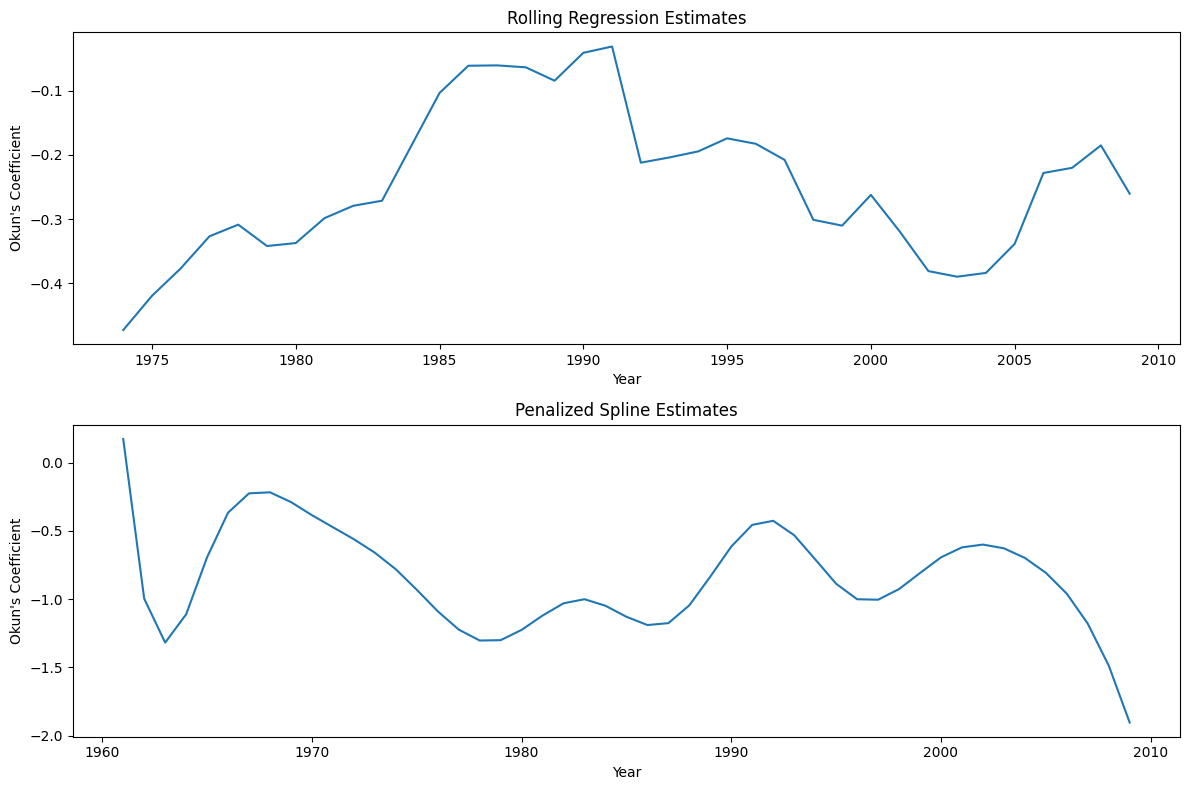

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Generate sample data (similar to paper's timeframe @27)
np.random.seed(123)
years = np.arange(1961, 2010)
n_samples = len(years)

# Generate synthetic data based on paper's model @7
gdp_growth = np.random.normal(3, 1, n_samples)
unemployment_change = -0.3 * gdp_growth + np.random.normal(0, 0.5, n_samples)

# 1. Rolling Regression
rolling_reg = RollingOkunRegression(window_size=14)
rolling_coefficients = rolling_reg.fit(gdp_growth, unemployment_change)

# 2. Penalized Spline
spline_reg = PenalizedSplineOkun(num_knots=10)
spline_coefficients = spline_reg.fit(years, gdp_growth, unemployment_change)

# Plotting
plt.figure(figsize=(12, 8))

# Plot 1: Rolling Regression
plt.subplot(2, 1, 1)
plt.plot(years[13:], rolling_coefficients, label='Rolling Regression')
plt.title("Rolling Regression Estimates")
plt.xlabel("Year")
plt.ylabel("Okun's Coefficient")

# Plot 2: Penalized Spline
plt.subplot(2, 1, 2)
plt.plot(years, spline_coefficients, label='Penalized Spline')
plt.title("Penalized Spline Estimates")
plt.xlabel("Year")
plt.ylabel("Okun's Coefficient")

plt.tight_layout()
plt.show()

In [ ]:
def optimize_smoothing_parameter(t, y, num_knots=10):
    """
    Optimize smoothing parameter using GCV as described in paper @22
    """
    def gcv_score(lamb):
        spline = LSQUnivariateSpline(
            t, y, 
            np.linspace(t.min(), t.max(), num_knots + 2)[1:-1],
            k=3, lamb=lamb
        )
        y_pred = spline(t)
        n = len(y)
        residuals = y - y_pred
        trace_A = spline.get_coeffs().size  # Effective degrees of freedom
        return n * np.sum(residuals**2) / (n - trace_A)**2
    
    # Optimize GCV score
    from scipy.optimize import minimize_scalar
    result = minimize_scalar(gcv_score, bounds=(1e-3, 1e3), method='bounded')
    return result.x